# Flow Network Solver

### General imports

In [1]:
# %pylab
# %run FastFlowNets.py 64 1 0
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sys, os
args = sys.argv
sys.executable

import numpy as np
import copy
from numpy import zeros as zeros
from numpy import ones as ones
from numpy import array as array
from numpy import arange as arange
from numpy import meshgrid as meshgrid
from numpy import dot as dot
from numpy.linalg import inv as inv

# import cupy as cp

import cProfile
import re
import time

import numpy.linalg as la
import numpy.random as rand
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from datetime import datetime

# My functions
import NETfuncs, Constraints, Matrixfuncs, Statistics, Classes, Big_Class, FileFuncs

In [2]:
## for plots and data save

# figure size
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams.update({'font.size': 14})

# comp_path = "C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\figs and data\\"
comp_path = "C:\\Users\\roiee\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\figs and data\\"

### Roie Larger Network

In [3]:
# User variables

NGrid = 8  # lattice dimension is Ngrid X Ngrid
# NGrid = 3  # lattice dimansion is Ngrid X Ngrid

# task_type = 'Allostery_one_pair'  # 1 pair of input and outputs
task_type = 'Allostery'  # 2 pairs of input and outputs
# task_type = 'Flow_clockwise'  # 2 pairs of input and outputs, test is flowing from both inputs to both outputs
# task_type = 'XOR'  # 2 inputs and 2 outputs. difference between output nodes encodes the XOR result of the 2 inputs
# task_type = 'Channeling_diag'  # 1st from input to diagonal output, then from output to 2 perpindicular nodes. 
#                                # test from input to output
# task_type = 'Channeling_straight' # 1st from input to output on same column, then from output to 2 perpindicular nodes. 
#                                   # test from input to output (same as 1st)
    
# row = int(np.floor(np.sqrt(NGrid))-1)  # row (and column) of input and output nodes in the NGrid X NGrid cell array
row = 3

# Assign input and output nodes a.f.o lattice size and row choice
input_output_pairs, fixed_nodes = Constraints.build_input_output_and_fixed(task_type, row, NGrid)

## These are defaults
# Periodic = False  # flag for lattice periodicity
# net_typ = 'Cells'  # layout for NETfuncs plotNetStructure(). 'Cells' is my style of network and is default
# u_thresh = 1  # threshold to move marbles

# Schemes to change conductivities and order of pressure appliance in training and test
if task_type == 'Allostery_one_pair':
    K_scheme = 'propto_current_squared'
    flow_scheme = 'one_shot'  # apply pressure drop from 1 output node and 1 output node, wait till convergence
elif task_type == 'Channeling_straight' or task_type == 'Channeling_diag':
    K_scheme = 'marbles_pressure'
    flow_scheme = 'one_shot'  # apply pressure drop from 1 output node and 1 output node, wait till convergence
else:
    K_scheme = 'marbles_pressure'
    flow_scheme = 'unidir'  # apply pressure drop only in the regular directions - constrained node = positive, ground = 0
                            # there are 2 input and output pairs, exchange between them
    # flow_scheme = 'taktak'  # apply pressure drop unidir once, meaning 1st input and output pair and then 2nd pair.
                              # then switch ground and constrained nodes to apply oposite dir.

# K_type = 'bidir'  # conductivity is the same regardless of flow directions
K_type = 'flow_dep'  # conductivity depends on flow direction - if into cell then maximal, 
                     # if out and there is a marble then lower

# Only for conductivity proportional to current squared scheme    
beta = 10**(-2)
# beta = 0
# print('beta is:' + str(beta))

K_max = 1
K_min = np.array([0.3])
# K_min = np.array([1/(4*(NGrid-2*row)-1)])  # theoretical marginal for channeling
# K_min = np.logspace(-4, 0, num=6, base=10)

# input_p = np.logspace(1, 5, num=6, base=10)
input_p = np.array([30])

iterations = 16  # # iterations allowed under flow cycles / updating conductivities

use_gpu = False
solver = Classes.Solver(use_gpu)
# if use_gpu == True:
#     import Solve_CUDA as Solve
# else:
#     import Solve

In [4]:
print(np.size(fixed_nodes))

0


In [5]:
## Prints

print('input output node pairs are:\n' + str(input_output_pairs) +'\n')

print('pressure is:')
for i in input_p:
    print(i)
    
print('\n K min is:')
for i in K_min:
    print(i)

input output node pairs are:
[[139 179]
 [184 144]]

pressure is:
30

 K min is:
0.3


In [6]:
## Variables class - mostly user choices

Variabs = Classes.User_variables(NGrid, input_p, flow_scheme, task_type, K_scheme, K_type, iterations, input_output_pairs, 
                                 Periodic='False', net_typ='Cells', u_thresh=1, fixed_nodes=fixed_nodes, 
                                 K_max=K_max, K_min=K_min, beta=beta)

In [7]:
## Big Class containing all classes in Network Simulation

BigClass = Big_Class.Big_Class(Variabs)

# CPU or GPU usage
BigClass.assign_solver(solver)

In [8]:
## Structure class - build incidence matrices and 1d arrays of edges

Strctr = Classes.Net_structure()
Strctr.build_incidence(Variabs)
BigClass.add_Strctr(Strctr)  # add to big class

In [9]:
## Initiate internal flow network state class

State = Classes.Net_state(use_gpu)
BigClass.add_State(State)  # add to big class

In [10]:
## build network graphics class and plot structure

NET = Classes.Networkx_net()
NET.buildNetwork(BigClass)
NET.build_pos_lattice(BigClass)
# position lattice, datatype of networkx
pos_lattice = NETfuncs.plotNetStructure(NET.NET, Variabs.NGrid, plot='no', node_labels=False)
BigClass.add_NET(NET)  # add to big class

NET is ready
NET is ready


In [11]:
def flow_iterate_for_profiler():
    State.flow_iterate(BigClass, sim_type='w marbles', plot='no', savefig='no') 

### Main part - loop over both cond and pressure

started main loop
CPU is used
cycle # 0
# iterations 3
cycle # 0
# iterations 3
cycle # 1
# iterations 3
cycle # 1
# iterations 3
cycle # 2
# iterations 3
cycle # 2
# iterations 4
cycle # 3
# iterations 4
cycle # 3
# iterations 3
cycle # 4
# iterations 4
loop break
         87440 function calls in 10.592 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   10.592   10.592 2418261943.py:1(flow_iterate_for_profiler)
       78    0.000    0.000    0.004    0.000 <__array_function__ internals>:177(all)
       18    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(concatenate)
      249    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(copyto)
      117    0.001    0.000    0.123    0.001 <__array_function__ internals>:177(dot)
       39    0.000    0.000   10.149    0.260 <__array_function__ internals>:177(inv)
        7    0.000    0.000    0.000    0.000 <__arra

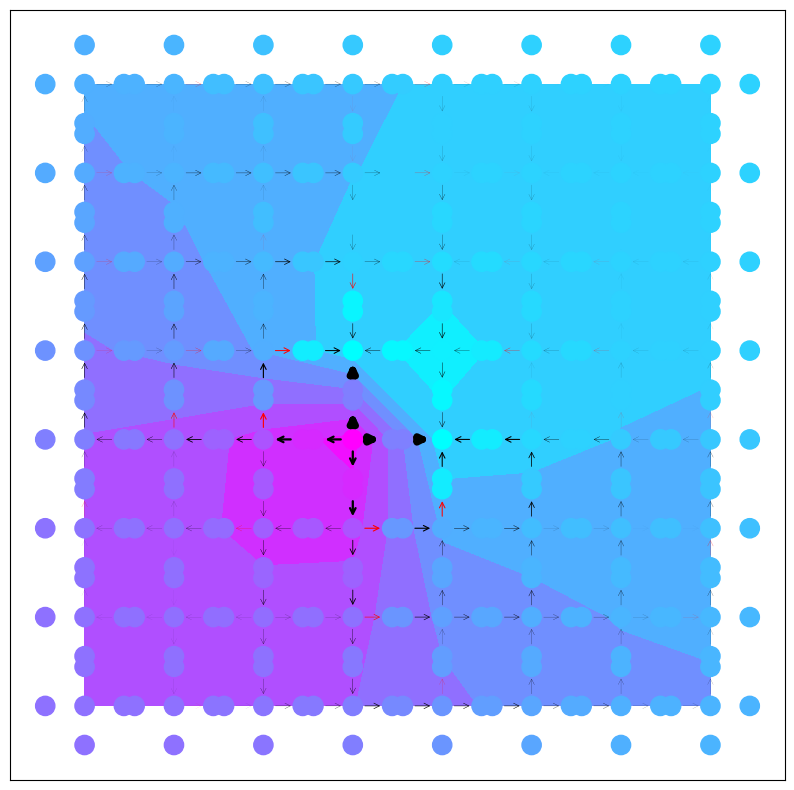

cycle # 0
condition supplied
[[ 0  5 10 15 20 25 30 35]
 [ 0  5 10 15 20 25 30 35]
 [ 0  5 10 15 20 25 30 35]
 [ 0  5 10 15 20 25 30 35]
 [ 0  5 10 15 20 25 30 35]
 [ 0  5 10 15 20 25 30 35]
 [ 0  5 10 15 20 25 30 35]
 [ 0  5 10 15 20 25 30 35]]
[[ 0  0  0  0  0  0  0  0]
 [ 5  5  5  5  5  5  5  5]
 [10 10 10 10 10 10 10 10]
 [15 15 15 15 15 15 15 15]
 [20 20 20 20 20 20 20 20]
 [25 25 25 25 25 25 25 25]
 [30 30 30 30 30 30 30 30]
 [35 35 35 35 35 35 35 35]]
[[ 5.40447373  5.40789159  5.50223944  5.78195323  6.41035792  7.28714825
   8.02549607  8.43835307]
 [ 5.41244269  5.3397352   5.27132628  5.39374641  6.08294051  7.38607486
   8.35098689  8.79733989]
 [ 5.49311913  5.27866708  4.84958404  4.43876565  4.72891527  7.82322378
   9.41051749 10.09575329]
 [ 5.78824762  5.43222994  4.40957716  2.2120857   4.38547327  9.19665635
  11.2219025  11.72512532]
 [ 6.43939378  6.13310279  4.59039569  3.89014545 21.72438128 17.74149914
  14.55531084 13.70751668]
 [ 7.27750582  7.39705335  7.742

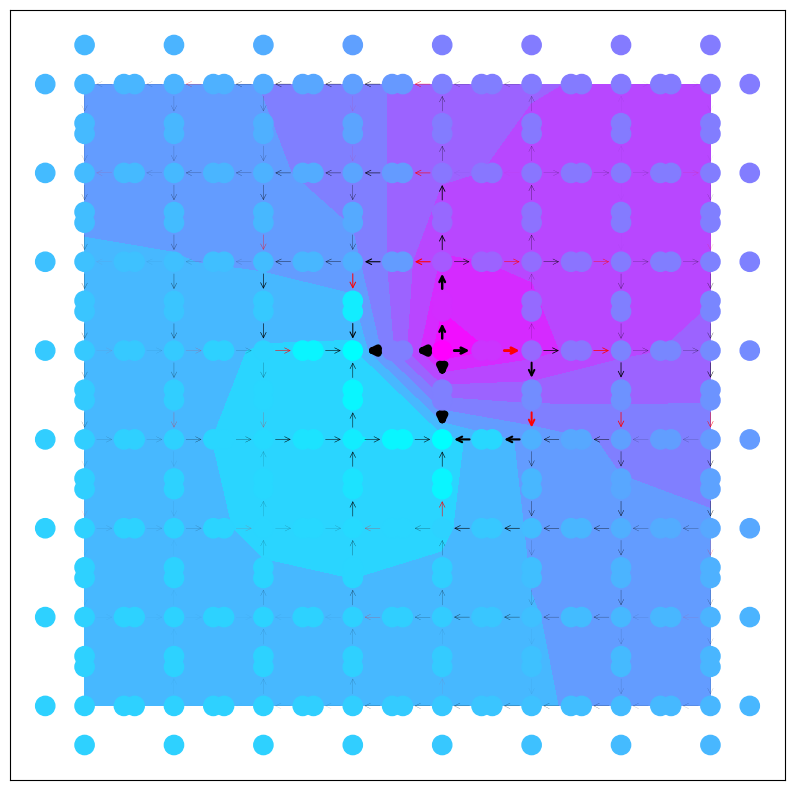

diagonality 1.073440
w_ij_norm 0.005153
total time for simulation 13.120379


In [13]:
# flow MSE and conductivity Hamming a.f.o input pressure

# Initiate MSE and Hamming matrices - MSE and Hamming for every iteration step (cols) a.f.o input p (rows)
MSE_arr = np.zeros([Variabs.iterations, len(K_min), len(input_p)])
Hamming_arr = np.zeros([Variabs.iterations, len(K_min), len(input_p)])
power_dissip_arr = np.zeros([Variabs.iterations, len(K_min), len(input_p)])
convergence_time_vec = np.zeros([len(K_min), len(input_p) ])
w_vec = np.zeros([len(K_min), len(input_p)])  # circulation
diagon_arr = np.zeros([len(K_min), len(input_p)])  # diagonality
u_allostery_arr = np.zeros([2, 2, len(K_min), len(input_p)])  # 

# Identify edges at connections of cells and at boundaries for ease of use
Strctr.Boundaries_and_connections(BigClass)

print('started main loop')
for i, K_min_i in enumerate(K_min):
    
    # K min into Variabs Class 
    Variabs.assign_K_min(K_min_i)
    
    for j, p in enumerate(input_p):
        
        start = time.time()  # time start of calculation for profiling

        # input pressure into Variabs Class
        Variabs.assign_input_p(p)

        # Set up constraints for whole loop
        Strctr.Setup_constraints(BigClass)

        # Initiate K matrix again, not mandatory, better not doing it actually
        State.initiateK(BigClass, noise='rand_u', noise_amp=0.5)
        # print(State.K)

        # Loop - Pose constraints, build constraints matrix, solve flow and update conductivities until convergence,
        #        change constraints and repeat
        
        cProfile.run('flow_iterate_for_profiler()')
        # State.flow_iterate(BigClass, sim_type='w marbles', plot='no', savefig='no')
        # State.flow_iterate(Variabs, Strctr, NET, sim_type='w marbles', plot='yes', savefig='yes')
        
        # print(State.K)

        MSE_arr[:, i, j] = State.MSE
        Hamming_arr[:, i, j] = State.Hamming
        # print(State.power_dissip)
        power_dissip_arr[:, i, j] = State.power_dissip
        convergence_time_vec[i, j] = State.convergence_time
        
        State.flow_iterate(BigClass, sim_type='allostery test', plot='yes', savefig='no')  # flow from both inputs
                                                                                           # to both outputs
        
        p_mat = Statistics.p_mat(BigClass, State.p)
#         R_typ = (1/1 + 1/1) * (NGrid-(2*row)) + 2
#         u_typ = input_p[0]/R_typ
        w_ij = Statistics.curl_direction(State.u, BigClass.Variabs.NGrid)  # calculate curl/vorticity
        
        a = State.u_final[0,0]
        b = State.u_final[0,1]
        c = State.u_final[1,0]
        d = State.u_final[1,1]
        diagon_ij = (a**2 + d**2)/(b**2 + c**2)
        print('diagonality %f' % diagon_ij)
        diagon_arr[i, j] = diagon_ij
        
        # w_vec[i, j] = w_ij/u_typ
        w_vec[i, j] = w_ij
        print('w_ij_norm %f' % w_vec[i, j])
        
        # FileFuncs.save_csv_files_Net(BigClass, p, K_min_i, comp_path)
      
#         datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
#         df_p = pd.DataFrame(np.array(State.p))
#         df_p.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_p=" + str(p) + "_K_ratio=" 
#                     + str(K_min_i) + "_p_field.csv")
#         df_u = pd.DataFrame(np.array(State.u_all[:,-1]))
#         df_u.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_p=" + str(p) + "_K_ratio=" 
#                     + str(K_min_i) + "_u_field.csv")
#         df_K = pd.DataFrame(np.array(State.K))
#         df_K.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_p=" + str(p) + "_K_ratio=" 
#                     + str(K_min_i) + "_K.csv")

        end = time.time()  # time end of calculation for profiling
        dt = end-start  # total time it took to run calculation
        print('total time for simulation %f' %dt)
        
convergence_time_vec[np.isnan(convergence_time_vec)] = Variabs.iterations

[[ 5.40447373  5.40789159  5.50223944  5.78195323  6.41035792  7.28714825
   8.02549607  8.43835307]
 [ 5.41244269  5.3397352   5.27132628  5.39374641  6.08294051  7.38607486
   8.35098689  8.79733989]
 [ 5.49311913  5.27866708  4.84958404  4.43876565  4.72891527  7.82322378
   9.41051749 10.09575329]
 [ 5.78824762  5.43222994  4.40957716  2.2120857   4.38547327  9.19665635
  11.2219025  11.72512532]
 [ 6.43939378  6.13310279  4.59039569  3.89014545 21.72438128 17.74149914
  14.55531084 13.70751668]
 [ 7.27750582  7.39705335  7.74219001  8.3423839  18.40890396 17.21402935
  15.55032504 14.84211389]
 [ 7.99607032  8.31608968  9.07807439 10.58524111 15.3980921  16.06197954
  15.58984608 15.26849995]
 [ 8.39461548  8.79316064  9.66877675 11.07588017 14.46061668 15.46654214
  15.47857979 15.37353987]]
17.214029353329323
8.342383899755506
9.196656354941346
2.2120857018004196


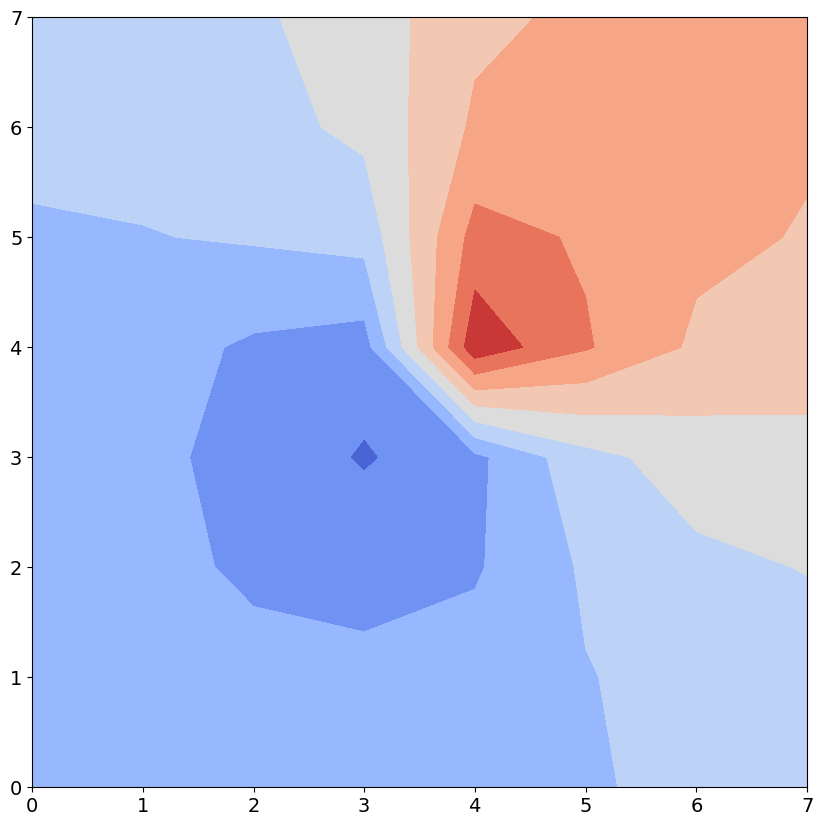

In [15]:
p_mat = Statistics.p_mat(BigClass, State.p)
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# fig, ax = plt.subplots()

# Make data.
X = np.arange(np.shape(p_mat)[0])
Y = np.arange(np.shape(p_mat)[1])
X, Y = np.meshgrid(X, Y)

# Plot the surface.
plt.contourf(X, Y, p_mat, cmap=plt.cm.coolwarm,
         linewidth=0, antialiased=False)

print(p_mat)
print(p_mat[NGrid-row,NGrid-row])
print(p_mat[NGrid-row,row])
print(p_mat[row,NGrid-row])
print(p_mat[row,row])

In [ ]:
Z = np.zeros(5)
Z1 = np.ones(5)
np.all(np.where(Z1==0.)[0]==np.where(Z==1.)[0])
np.where(Z1==0.)[0]==np.where(Z==0.)[0]

In [ ]:
# Save inportant data as CSV

# import pandas as pd 

datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
print(datenow)

# df1 = pd.DataFrame(u_allostery_arr)
# print('C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network\\u_allostery' + str(datenow) + '.csv')
# df1.to_csv("C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network\\u_allostery" + str(datenow) + ".csv")
# df2 = pd.DataFrame(w_vec)
# df2.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_w_vec.csv")
df2 = pd.DataFrame(w_vec, columns=[str(i) for i in input_p], index=[str(i) for i in K_min])
df2.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_w_vec.csv")
df2 = pd.DataFrame(diagon_arr, columns=[str(i) for i in input_p], index=[str(i) for i in K_min])
df2.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_diagon_arr.csv")

In [ ]:
df2 = pd.DataFrame(w_vec, columns=[str(i) for i in input_p], index=[str(i) for i in K_min])
df2.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_w_vec.csv")

In [ ]:
## Figures

# prelims for figures
datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
print(datenow)

# fig 1 - MSE, Hamming and Power dissip. afo p

fig1, axes1 = plt.subplots(nrows=3)
# axes.set_color_cycle(['332288', '88CCEE', '44AA99', '117733', '999933', 'DDCC77', 'CC6677', '882255', 'AA4499'])
# cmap = plt.get_cmap('cool')
cmap = sns.cubehelix_palette(as_cmap=True)
colors = [cmap(i) for i in np.linspace(0, 1, len(MSE_arr[0,:]))]
legend_every = 10

for i, color in enumerate(colors, start=0):
    if i % legend_every == 0:
        axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color, label='K ratio='+str(K_min[i]))
    else:
        axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color)
    axes1[1].plot(range(len(MSE_arr[:,0])), Hamming_arr[:,i], color=color)
    axes1[2].plot(range(len(MSE_arr[:,0])), power_dissip_arr[:,i]/input_p[0], color=color)
axes1[0].legend()
# plt.show()
axes1[2].set_xlabel('iteration #')
axes1[0].set_ylabel('flow MSE')
axes1[1].set_ylabel('Hamming dist.')
axes1[2].set_ylabel('power')

## Save last figure as PNG with proper time
plt.savefig(comp_path + 'distance_and_P_afo_Kratio_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# fig 2 - # cycles until convergence and tau p

fig2, axes2 = plt.subplots(nrows=2, figsize=(10,6))
axes2[0].semilogx(K_min, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
axes2[0].set_ylabel('# cycles')
# axes2[1].plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# axes2[1].set_xlabel('input $p$')
# axes2[1].set_ylabel('$\\theta$')
axes2[1].semilogx(K_min, w_vec, '.', ms=20, mfc='white', label='$\\tau$')
axes2[1].semilogx(K_min, np.zeros([len(K_min),]))
axes2[1].set_xlabel('$\\frac{K_{min}}{K_{max}}$')
axes2[1].set_ylabel('$\\tau$')

## Save last figure as PNG with proper time
plt.savefig(comp_path + 'numCycles_and_tau_afo_Kratio_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

In [ ]:
State.u_final

In [ ]:
np.mean(np.abs(State.u))*NGrid**2
# R_typ1 = (1/1 + 1/K_min[0])**(-1) * (NGrid-(2*row))
R_typ2 = (1/1 + 1/1)**(-1) * (NGrid-(2*row))
R_typ1 = R_typ2
R_typ = (R_typ1 + R_typ2)/2
u_typ = input_p[0]/R_typ
print(u_typ)
print(w_vec)
print(w_vec/u_typ)

In [ ]:
# NGrid = 12
# u = State.u

NGrid = 2
row = 0
delta_p = 4
# u = np.array([1, 0, -1, 0, 2, 0, -2, 0, 3, 0, -3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
#               -3, 0, 3, 0, -2, 0, 2, 0, -1, 0, 1, 0])
# u = np.array([0, 1, 0, -1, 0, 0, 0, 0, 0, -3, 0, 3, 0 , 2, 0, -2, 0, 0, 0, 0, 0, -2, 0, 
#               2, 0, 3, 0, -3, 0, 0, 0, 0, 0, -1, 0, 1])
u = 1*np.array([0, 1, 0, -1, 0, -1, 0, 1, 0, 1, 0, -1, 0, -1, 0, 1])
print(np.size(u))
u_by_cells = np.zeros([NGrid*NGrid,2])
for i in range(NGrid*NGrid):
    u_by_cells[i,0] = (u[4*i]+(-u[4*i+2]))/2
    u_by_cells[i,1] = (u[4*i+1]+(-u[4*i+3]))/2
u_by_cells = np.reshape(u_by_cells, [NGrid, NGrid, 2])
u_by_cells_mag = np.sqrt(u_by_cells[:,:,0]**2+u_by_cells[:,:,1]**2)

print(u_by_cells[:,:,0])
print(u_by_cells[:,:,1])

print(u_by_cells_mag)
# R_typ = (1/1 + 1/1) * (NGrid-(2*row))
# u_typ = delta_p/R_typ
u_typ=1
# print('u_typ %f' % u_typ)

w = Statistics.curl_direction(u, NGrid)
w_norm = w/u_typ
print('u %f' % np.mean(np.abs(u_by_cells_mag)))
print('w %f' % w)
print('w_norm %f' % w_norm)

# print('u_by_cells')
# print(u_by_cells[:,:,0])
# print(u_by_cells[:,:,1])

# dxuy = np.append(np.diff(u_by_cells[:,:,1],axis=1).T, [np.diff(u_by_cells[:,:,1],axis=1)[:,-1]], axis=0).T
# print('dxuy')
# print(dxuy)
# dyux = np.append(np.diff(u_by_cells[:,:,0],axis=0), [np.diff(u_by_cells[:,:,0],axis=0)[-1,:]], axis=0)
# print('dyux')
# print(dyux)
# curl = dxuy-dyux
# u_mean = np.mean(np.mean(np.abs(u_by_cells)))
# print('u_mean is %f' % u_mean)
# curl_norm = curl/u_mean
# print(curl_norm)
# print(np.mean(np.mean(curl_norm)))

### Main part - loop over many conductivity ratios

In [ ]:
# # flow MSE and conductivity Hamming a.f.o input pressure

# # Initiate MSE and Hamming matrices - MSE and Hamming for every iteration step (cols) a.f.o input p (rows)
# MSE_arr = np.zeros([Variabs.iterations, len(K_min)])
# Hamming_arr = np.zeros([Variabs.iterations, len(K_min)])
# power_dissip_arr = np.zeros([Variabs.iterations, len(K_min)])
# convergence_time_vec = np.zeros([len(K_min), ])
# shear_vec = np.zeros([len(K_min), ])  # 
# u_allostery_arr = np.zeros([2, 2, len(K_min)])  # 

# # Identify edges at connections of cells and at boundaries for ease of use
# Strctr.Boundaries_and_connections(Variabs)

# origin = np.array([[0, 0],[0, 0]]) # origin point

# print('started main loop')

# for i, K_min_i in enumerate(K_min):
    
#     # save variables into class
#     Variabs.assign_K_min(K_min_i)
    
#     # Set up constraints for whole loop
#     Strctr.Setup_constraints(Variabs)
    
#     # Initiate K matrix again, not mandatory, better not doing it actually
#     State.initiateK(Variabs, Strctr, noise='yes')
#     print(State.K)
    
#     # Loop - Pose constraints, build constraints matrix, solve flow and update conductivities until convergence,
#     #        change constraints and repeat
#     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'no')
    
#     MSE_arr[:, i] = State.MSE
#     Hamming_arr[:, i] = State.Hamming
#     # print(State.power_dissip)
#     power_dissip_arr[:, i] = State.power_dissip
#     convergence_time_vec[i] = State.convergence_time
    
#     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
#     print(State.u_final)
    
# #     Variabs.iterations = 1
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'yes')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
# #     print(State.u_final)
    
# #     Variabs.iterations = 2
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'yes')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
# #     print(State.u_final)
    
# #     Variabs.iterations = 3
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'no')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'last')
# #     print(State.u_final)
    
# #     Variabs.iterations = iterations
    
#     u_allostery_arr[:,:, i] = State.u_final
#     shear_vec[i] = Statistics.shear_type(State.u_final)
#     print('shear is: ' + str(shear_vec[i]))
    
#     print(str((i+1)*100/len(K_min)) + '% done')

# convergence_time_vec[np.isnan(convergence_time_vec)] = Variabs.iterations

In [ ]:
# print(np.mean(State.p))
# np.max(State.p)

In [ ]:
# ## Figures

# # prelims for figures
# datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
# print(datenow)

# # fig 1 - MSE, Hamming and Power dissip. afo p

# fig1, axes1 = plt.subplots(nrows=3)
# # axes.set_color_cycle(['332288', '88CCEE', '44AA99', '117733', '999933', 'DDCC77', 'CC6677', '882255', 'AA4499'])
# # cmap = plt.get_cmap('cool')
# cmap = sns.cubehelix_palette(as_cmap=True)
# colors = [cmap(i) for i in np.linspace(0, 1, len(MSE_arr[0,:]))]
# legend_every = 10

# for i, color in enumerate(colors, start=0):
#     if i % legend_every == 0:
#         axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color, label='K ratio='+str(K_min[i]))
#     else:
#         axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color)
#     axes1[1].plot(range(len(MSE_arr[:,0])), Hamming_arr[:,i], color=color)
#     axes1[2].plot(range(len(MSE_arr[:,0])), power_dissip_arr[:,i]/input_p[0], color=color)
# axes1[0].legend()
# # plt.show()
# axes1[2].set_xlabel('iteration #')
# axes1[0].set_ylabel('flow MSE')
# axes1[1].set_ylabel('Hamming dist.')
# axes1[2].set_ylabel('power')

# ## Save last figure as PNG with proper time
# plt.savefig(comp_path + 'distance_and_P_afo_Kratio_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# # fig 2 - # cycles until convergence and tau p

# fig2, axes2 = plt.subplots(nrows=2, figsize=(10,6))
# axes2[0].semilogx(K_min, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
# axes2[0].set_ylabel('# cycles')
# # axes2[1].plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# # axes2[1].set_xlabel('input $p$')
# # axes2[1].set_ylabel('$\\theta$')
# axes2[1].semilogx(K_min, shear_vec, '.', ms=20, mfc='white', label='$\\tau$')
# axes2[1].semilogx(K_min, np.zeros([len(K_min),]))
# axes2[1].set_xlabel('$\\frac{K_{min}}{K_{max}}$')
# axes2[1].set_ylabel('$\\tau$')

# ## Save last figure as PNG with proper time
# plt.savefig(comp_path + 'numCycles_and_tau_afo_Kratio_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# # fig2 = plt.figure(figsize = (10,4))
# # plt.plot(input_p, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
# # plt.xlabel('input $p$')
# # plt.ylabel('# cycles')
# # # plt.legend(loc='upper right')
# # plt.legend()

# # plt.show()

# # fig3 = plt.figure(figsize = (10,4))
# # plt.plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# # plt.xlabel('input $p$')
# # plt.ylabel('$\\theta$')
# # # plt.legend(loc='upper right')
# # plt.legend()

### Main part - loop over many pressures

In [ ]:
# # flow MSE and conductivity Hamming a.f.o input pressure

# # Initiate MSE and Hamming matrices - MSE and Hamming for every iteration step (cols) a.f.o input p (rows)
# MSE_arr = np.zeros([Variabs.iterations, len(input_p)])
# Hamming_arr = np.zeros([Variabs.iterations, len(input_p)])
# power_dissip_arr = np.zeros([Variabs.iterations, len(input_p)])
# convergence_time_vec = np.zeros([len(input_p), ])
# # theta_vec = np.zeros([len(input_p), ])
# shear_vec = np.zeros([len(input_p), ])  # 
# u_allostery_arr = np.zeros([2, 2, len(input_p)])  # 

# # Identify edges at connections of cells and at boundaries for ease of use
# Strctr.Boundaries_and_connections(Variabs)

# origin = np.array([[0, 0],[0, 0]]) # origin point

# print('started main loop')

# for i, p in enumerate(input_p):
    
#     # save variables into class
#     Variabs.assign_input_p(p)
    
#     # Set up constraints for whole loop
#     Strctr.Setup_constraints(Variabs)
    
#     # Initiate K matrix again, not mandatory, better not doing it actually
#     State.initiateK(Variabs, Strctr, noise='no')
    
#     # Loop - Pose constraints, build constraints matrix, solve flow and update conductivities until convergence,
#     #        change constraints and repeat
#     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', plot='no', savefig='no')
    
#     MSE_arr[:, i] = State.MSE
#     Hamming_arr[:, i] = State.Hamming
#     power_dissip_arr[:, i] = State.power_dissip
#     convergence_time_vec[i] = State.convergence_time
    
#     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
#     print(State.u_final)
    
# #     Variabs.iterations = 1
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'yes')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
# #     print(State.u_final)
    
# #     Variabs.iterations = 2
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'yes')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes')
# #     print(State.u_final)
    
# #     Variabs.iterations = 3
# #     State.flow_iterate(Variabs, Strctr, NET, 'w marbles', 'no')
# #     State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'last')
# #     print(State.u_final)
    
# #     Variabs.iterations = iterations
    
#     u_allostery_arr[:,:, i] = State.u_final
#     shear_vec[i] = Statistics.shear_type(State.u_final)
#     print('shear is: ' + str(shear_vec[i]))
    
#     print(str((i+1)*100/len(input_p)) + '% done')

# convergence_time_vec[np.isnan(convergence_time_vec)] = Variabs.iterations

In [ ]:
# State.flow_iterate(Variabs, Strctr, NET, 'allostery test', 'yes', savefig='yes')

In [ ]:
# ## Figures

# # prelims for figures
# datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
# print(datenow)

# # fig 1 - MSE, Hamming and Power dissip. afo p

# fig1, axes1 = plt.subplots(nrows=3)
# # axes.set_color_cycle(['332288', '88CCEE', '44AA99', '117733', '999933', 'DDCC77', 'CC6677', '882255', 'AA4499'])
# # cmap = plt.get_cmap('cool')
# cmap = sns.cubehelix_palette(as_cmap=True)
# colors = [cmap(i) for i in np.linspace(0, 1, len(MSE_arr[0,:]))]
# legend_every = 10

# for i, color in enumerate(colors, start=0):
#     if i % legend_every == 0:
#         axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color, label='p='+str(input_p[i]))
#     else:
#         axes1[0].plot(range(len(MSE_arr[:,0])), MSE_arr[:,i], color=color)
#     axes1[1].plot(range(len(MSE_arr[:,0])), Hamming_arr[:,i], color=color)
#     axes1[2].plot(range(len(MSE_arr[:,0])), power_dissip_arr[:,i]/input_p[i], color=color)
# axes1[0].legend()
# # plt.show()
# axes1[2].set_xlabel('iteration #')
# axes1[0].set_ylabel('flow MSE')
# axes1[1].set_ylabel('Hamming dist.')
# axes1[2].set_ylabel('power')

# ## Save last figure as PNG with proper time
# plt.savefig(comp_path + 'distance_and_P_afo_p_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# # fig 2 - # cycles until convergence and tau p

# fig2, axes2 = plt.subplots(nrows=2, figsize=(10,6))
# axes2[0].semilogx(input_p, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
# axes2[0].set_ylabel('# cycles')
# # axes2[1].plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# # axes2[1].set_xlabel('input $p$')
# # axes2[1].set_ylabel('$\\theta$')
# axes2[1].semilogx(input_p, shear_vec, '.', ms=20, mfc='white', label='$\\tau$')
# axes2[1].semilogx(input_p, np.zeros([len(input_p),]))
# axes2[1].set_xlabel('input $p$')
# axes2[1].set_ylabel('$\\tau$')

# ## Save last figure as PNG with proper time
# plt.savefig(comp_path + 'numCycles_and_tau_afo_p_' + "_grid=" + str(NGrid) + "_" + str(datenow) + '.png')

# # fig2 = plt.figure(figsize = (10,4))
# # plt.plot(input_p, convergence_time_vec, '.', ms=20, mfc='white', label='# cycles until convergence')
# # plt.xlabel('input $p$')
# # plt.ylabel('# cycles')
# # # plt.legend(loc='upper right')
# # plt.legend()

# # plt.show()

# # fig3 = plt.figure(figsize = (10,4))
# # plt.plot(input_p, theta_vec, '.', ms=20, mfc='white', label='$\\theta$')
# # plt.xlabel('input $p$')
# # plt.ylabel('$\\theta$')
# # # plt.legend(loc='upper right')
# # plt.legend()

In [ ]:
# # Save inportant data as CSV

# # import pandas as pd 

# datenow = datetime.today().strftime('%Y_%m_%d_%H_%M_%S')
# print(datenow)

# # df1 = pd.DataFrame(u_allostery_arr)
# # print('C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network\\u_allostery' + str(datenow) + '.csv')
# # df1.to_csv("C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network\\u_allostery" + str(datenow) + ".csv")
# df2 = pd.DataFrame(np.array([K_min, convergence_time_vec, shear_vec]))
# df2.to_csv(comp_path + str(datenow) + "_grid=" + str(NGrid) + "_shear_vec.csv")